# Bike Sharing

In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
df = pd.read_csv("hour(1).csv")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


#### Features
X	
    - instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users

Y	
    - cnt: count of total rental bikes including both casual and registered - Target Variable

## 0. 각종 분석을 통한 데이터 파악 (예, 변수간의 상관관계, 변수들의 분포, 등등)  

In [3]:
df.info() # 결측치는 존재하지 않음.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [4]:
df=df.drop(['instant'], axis=1) # instant 변수는 record index로 분석에 영향을 주지 않는 변수로 판단하여 삭제함.

In [5]:
numerical_variables=['temp','atemp','hum','windspeed','casual','registered']
categorical_variables=['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
target_variable=['cnt']
df[categorical_variables]=df[categorical_variables].astype('object')
df.dtypes

dteday         object
season         object
yr             object
mnth           object
hr             object
holiday        object
weekday        object
workingday     object
weathersit     object
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

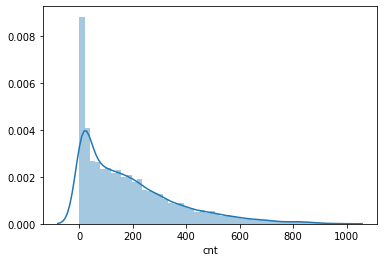

In [6]:
sns.distplot(df['cnt'])
plt.show()

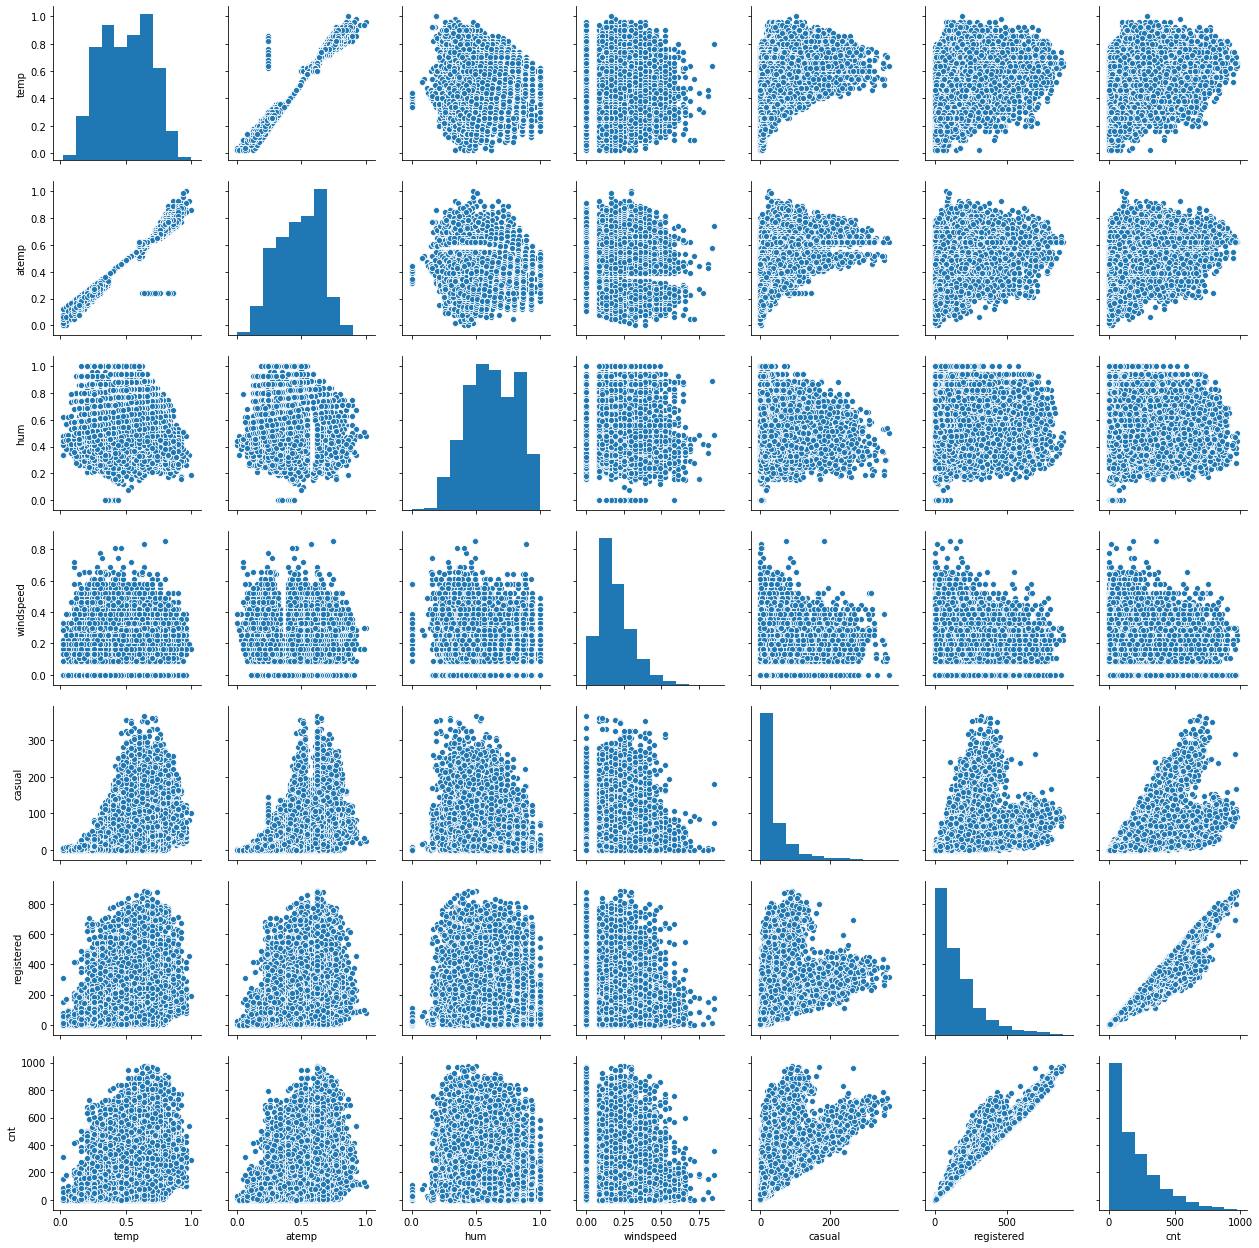

In [7]:
sns.pairplot(df[numerical_variables + target_variable])
plt.show()

In [8]:
df.corr()

,temp,atemp,hum,windspeed,casual,registered,cnt
temp,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772
atemp,0.987672,1.000000,-0.051918,-0.062336,0.454080,0.332559,0.400929
hum,-0.069881,-0.051918,1.000000,-0.290105,-0.347028,-0.273933,-0.322911
windspeed,-0.023125,-0.062336,-0.290105,1.000000,0.090287,0.082321,0.093234
casual,0.459616,0.454080,-0.347028,0.090287,1.000000,0.506618,0.694564
registered,0.335361,0.332559,-0.273933,0.082321,0.506618,1.000000,0.972151
cnt,0.404772,0.400929,-0.322911,0.093234,0.694564,0.972151,1.000000


In [9]:
corr=abs(df.corr()['cnt']).sort_values(ascending = False)
corr

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hum           0.322911
windspeed     0.093234
Name: cnt, dtype: float64

In [10]:
df.describe()

,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


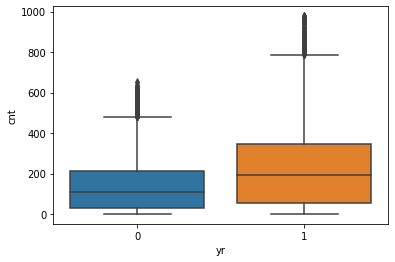

In [11]:
sns.boxplot(x=df['yr'], y=df['cnt'])
plt.show()

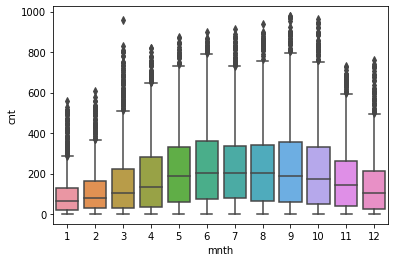

In [12]:
sns.boxplot(x=df['mnth'], y=df['cnt'])
plt.show()

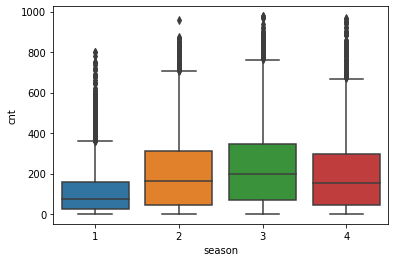

In [13]:
sns.boxplot(x=df['season'], y=df['cnt'])
plt.show()

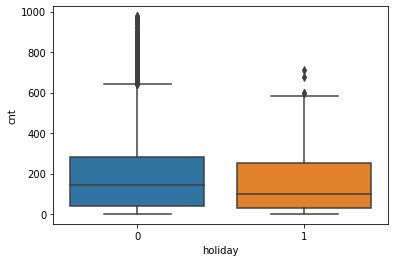

In [14]:
sns.boxplot(x=df['holiday'], y=df['cnt'])
plt.show()

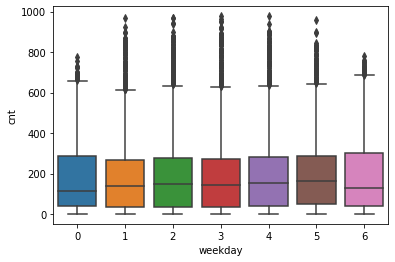

In [15]:
sns.boxplot(x=df['weekday'], y=df['cnt'])
plt.show()

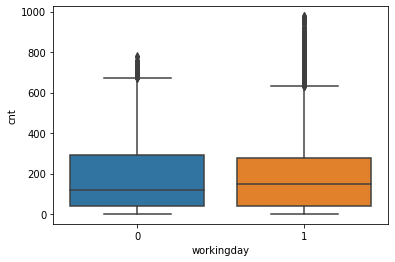

In [16]:
sns.boxplot(x=df['workingday'], y=df['cnt'])
plt.show()

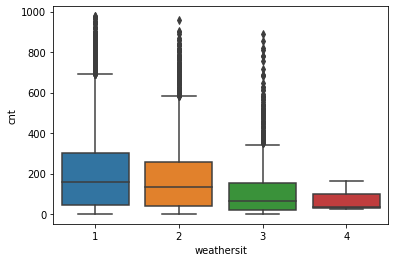

In [17]:
sns.boxplot(x=df['weathersit'], y=df['cnt'])
plt.show()

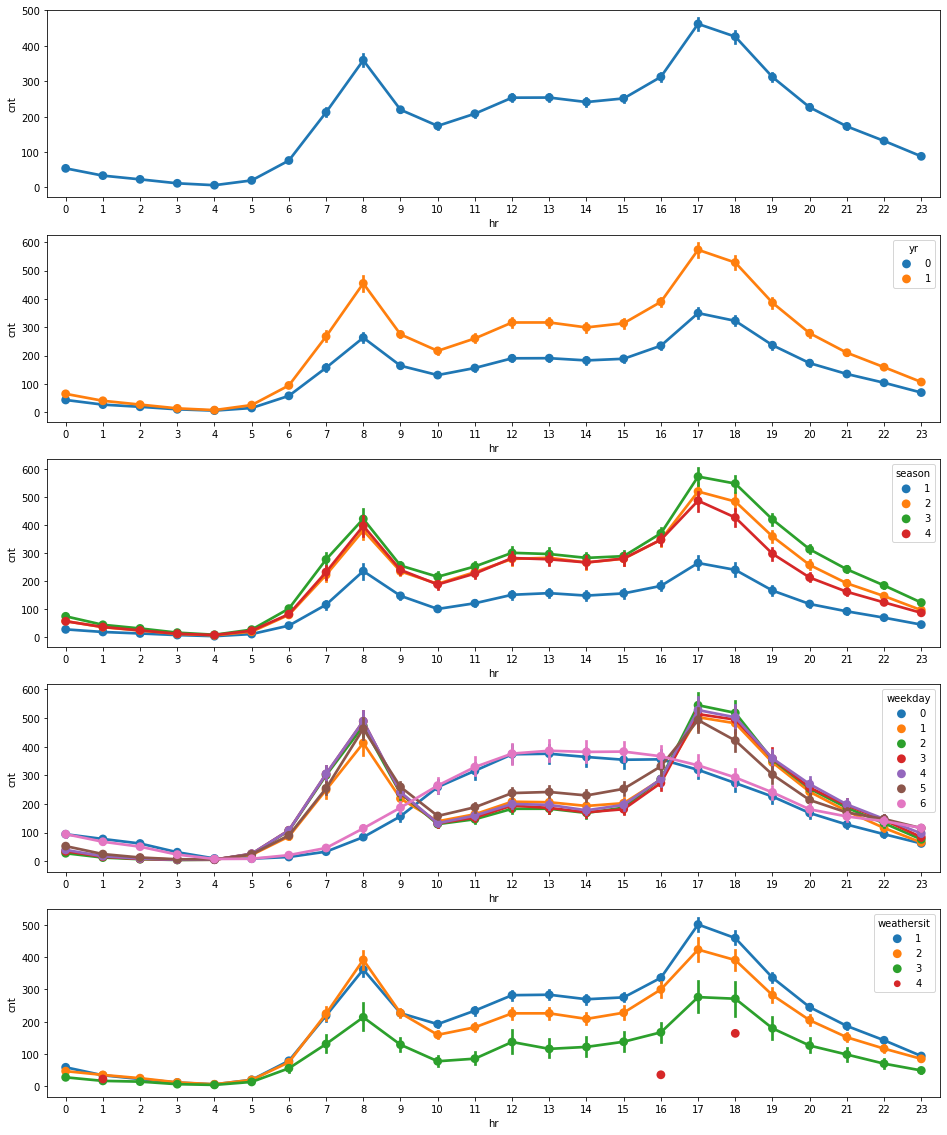

In [18]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows = 5)
fig.set_size_inches(16,20)
sns.pointplot(data=df, x="hr", y="cnt", ax=ax1)
sns.pointplot(data=df, x="hr", y="cnt", hue="yr", ax=ax2)
sns.pointplot(data=df, x="hr", y="cnt", hue="season", ax=ax3)
sns.pointplot(data=df, x="hr", y="cnt", hue="weekday", ax=ax4)
sns.pointplot(data=df, x="hr", y="cnt", hue="weathersit", ax=ax5)
plt.show()

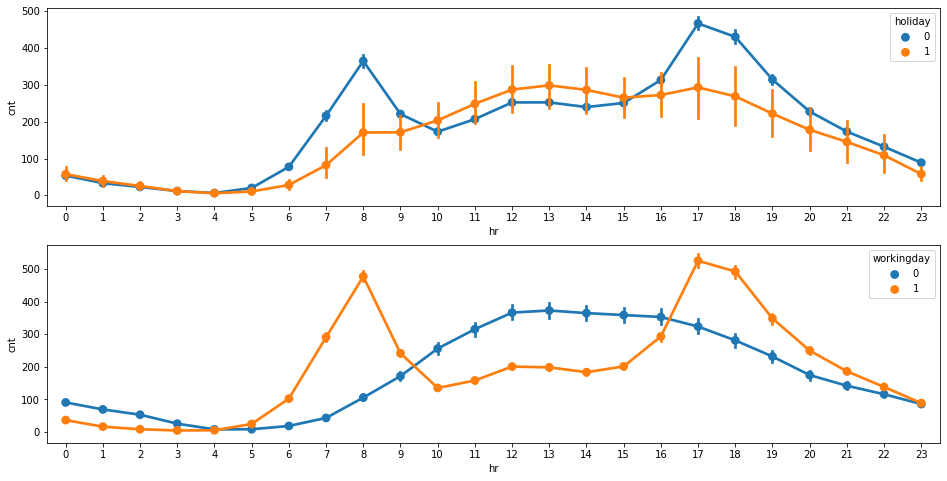

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows = 2)
fig.set_size_inches(16,8)
sns.pointplot(data=df, x="hr", y="cnt", hue="holiday", ax=ax1)
sns.pointplot(data=df, x="hr", y="cnt", hue="workingday", ax=ax2)
plt.show()

## 1. 다중회귀모델 구축 및 해석 (R2, Adjusted R2 포함)

In [20]:
sm.OLS.from_formula("cnt ~ temp", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     3405.
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        11:33:23   Log-Likelihood:            -1.1349e+05
No. Observations:               17379   AIC:                         2.270e+05
Df Residuals:                   17377   BIC:                         2.270e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0356      3.483     -0.010      0.992      -6.862       6.791
temp         381.2949      6.534     58.352      0.000     368.487     394.103
==============================================================================
Omnibus:                     3140.760   Durbin-Watson:                   0.368
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5634.907
Skew:                           1.152   Prob(JB):                         0.00
Kurtosis:                       4.572   Cond. No.                         6.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
sm.OLS.from_formula("cnt ~ atemp", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     3328.
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        11:33:23   Log-Likelihood:            -1.1352e+05
No. Observations:               17379   AIC:                         2.270e+05
Df Residuals:                   17377   BIC:                         2.271e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.8755      3.711     -3.200      0.001     -19.149      -4.602
atemp        423.1802      7.335     57.691      0.000     408.802     437.558
==============================================================================
Omnibus:                     3130.969   Durbin-Watson:                   0.369
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5604.352
Skew:                           1.150   Prob(JB):                         0.00
Kurtosis:                       4.565   Cond. No.                         7.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
df_ols=df[['season','hr','workingday','weathersit','temp','hum','windspeed','casual','cnt']]
df_ols.head()

,season,hr,workingday,weathersit,temp,hum,windspeed,casual,cnt
0,1,0,0,1,0.24,0.81,0.0,3,16
1,1,1,0,1,0.22,0.80,0.0,8,40
2,1,2,0,1,0.22,0.80,0.0,5,32
3,1,3,0,1,0.24,0.75,0.0,3,13
4,1,4,0,1,0.24,0.75,0.0,0,1


In [23]:
sm.OLS.from_formula("cnt ~ season+hr+workingday+weathersit+temp+hum+windspeed+casual", data=df_ols).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     1824.
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        11:33:24   Log-Likelihood:            -1.0183e+05
No. Observations:               17379   AIC:                         2.037e+05
Df Residuals:                   17344   BIC:                         2.040e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -46.1549      4.909     -9.402      0.000     -55.777     -36.533
season[T.2]        10.0387      2.346      4.279      0.000       5.441      14.637
season[T.3]        15.5819      3.015      5.168      0.000       9.673      21.491
season[T.4]        45.7920      2.026     22.597      0.000      41.820      49.764
hr[T.1]           -11.2249      4.460     -2.517      0.012     -19.967      -2.483
hr[T.2]           -17.1420      4.475     -3.830      0.000     -25.914      -8.370
hr[T.3]           -23.0271      4.507     -5.109      0.000     -31.862     -14.193
hr[T.4]           -24.2759      4.511     -5.382      0.000     -33.117     -15.434
hr[T.5]           -11.6838      4.480     -2.608      0.009     -20.465      -2.903
hr[T.6]            39.7759      4.467      8.904      0.000      31.020      48.532
hr[T.7]           160.7436      4.461     36.034      0.000     152.000     169.487
hr[T.8]           281.7340      4.464     63.108      0.000     272.983     290.485
hr[T.9]           118.7277      4.478     26.512      0.000     109.950     127.506
hr[T.10]           35.6346      4.521      7.883      0.000      26.774      44.495
hr[T.11]           38.0457      4.577      8.312      0.000      29.074      47.017
hr[T.12]           62.0023      4.631     13.388      0.000      52.924      71.080
hr[T.13]           51.7424      4.663     11.097      0.000      42.603      60.882
hr[T.14]           30.8643      4.691      6.580      0.000      21.670      40.058
hr[T.15]           42.4539      4.692      9.047      0.000      33.256      51.652
hr[T.16]          106.3474      4.682     22.716      0.000      97.171     115.524
hr[T.17]          256.3195      4.670     54.886      0.000     247.166     265.473
hr[T.18]          250.5182      4.603     54.423      0.000     241.496     259.541
hr[T.19]          165.4320      4.538     36.454      0.000     156.537     174.327
hr[T.20]          109.9172      4.496     24.450      0.000     101.105     118.729
hr[T.21]           75.0256      4.472     16.778      0.000      66.261      83.790
hr[T.22]           48.5908      4.461     10.893      0.000      39.848      57.334
hr[T.23]           22.4864      4.455      5.048      0.000      13.755      31.218
workingday[T.1]    80.5124      1.540     52.277      0.000      77.494      83.531
weathersit[T.2]     0.1331      1.596      0.083      0.934      -2.995       3.262
weathersit[T.3]   -37.8021      2.695    -14.024      0.000     -43.085     -32.519
weathersit[T.4]   -34.6554     49.099     -0.706      0.480    -130.893      61.583
temp               71.8301      6.149     11.681      0.000      59.777      83.883
hum               -35.6665      4.512     -7.904      0.000     -44.511     -26.822
windspeed          -7.2993      5.682     -1.285      0.199

In [24]:
sm.OLS.from_formula("cnt ~ season+hr+workingday+weathersit+temp+hum+windspeed", data=df_ols).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     880.6
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        11:33:24   Log-Likelihood:            -1.0649e+05
No. Observations:               17379   AIC:                         2.130e+05
Df Residuals:                   17345   BIC:                         2.133e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -24.7186      6.414     -3.854      0.000     -37.290     -12.147
season[T.2]        36.0461      3.052     11.810      0.000      30.064      42.029
season[T.3]        16.0414      3.942      4.069      0.000       8.314      23.769
season[T.4]        62.7276      2.642     23.740      0.000      57.548      67.907
hr[T.1]           -16.8908      5.831     -2.897      0.004     -28.321      -5.461
hr[T.2]           -25.0394      5.851     -4.279      0.000     -36.508     -13.571
hr[T.3]           -34.9974      5.892     -5.940      0.000     -46.546     -23.449
hr[T.4]           -37.0643      5.896     -6.286      0.000     -48.622     -25.507
hr[T.5]           -20.9373      5.857     -3.575      0.000     -32.417      -9.457
hr[T.6]            37.5354      5.841      6.426      0.000      26.086      48.984
hr[T.7]           171.9608      5.832     29.488      0.000     160.530     183.391
hr[T.8]           311.3621      5.827     53.433      0.000     299.940     322.784
hr[T.9]           161.9870      5.834     27.768      0.000     150.552     173.421
hr[T.10]          105.4493      5.854     18.015      0.000      93.976     116.923
hr[T.11]          129.1032      5.888     21.926      0.000     117.562     140.645
hr[T.12]          166.9709      5.928     28.165      0.000     155.351     178.591
hr[T.13]          161.0567      5.959     27.026      0.000     149.376     172.737
hr[T.14]          144.6419      5.985     24.167      0.000     132.910     156.374
hr[T.15]          153.8659      5.994     25.671      0.000     142.117     165.614
hr[T.16]          216.1842      5.983     36.131      0.000     204.456     227.912
hr[T.17]          370.6279      5.956     62.227      0.000     358.953     382.302
hr[T.18]          339.7800      5.927     57.332      0.000     328.163     351.397
hr[T.19]          232.6263      5.881     39.556      0.000     221.099     244.154
hr[T.20]          154.2704      5.855     26.347      0.000     142.793     165.747
hr[T.21]          105.8343      5.836     18.135      0.000      94.395     117.273
hr[T.22]           69.6133      5.827     11.946      0.000      58.191      81.036
hr[T.23]           31.3627      5.824      5.385      0.000      19.947      42.778
workingday[T.1]     6.5003      1.815      3.581      0.000       2.942      10.058
weathersit[T.2]    -6.2048      2.086     -2.975      0.003     -10.293      -2.117
weathersit[T.3]   -61.3319      3.514    -17.455      0.000     -68.219     -54.445
weathersit[T.4]   -37.9089     64.202     -0.590      0.555    -163.751      87.933
temp              275.3857      7.675     35.883      0.000     260.343     290.429
hum              -101.0560      5.850    -17.275      0.000    -112.522     -89.590
windspeed         -45.1131      7.417     -6.083      0.000

## 2. 다중회귀모델 가정을 충족하는지 확인하고 충족하지 않을 경우 충족하도록 변환 (변수 Log Transform 등)

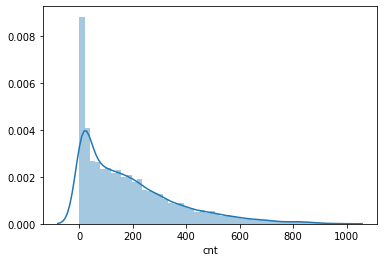

In [25]:
sns.distplot(df.cnt)
plt.show()

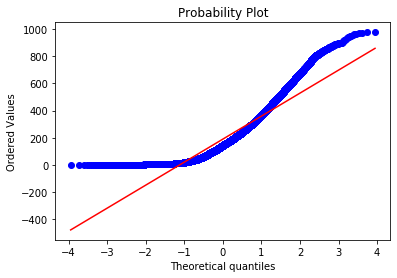

In [26]:
sp.stats.probplot(df_ols.cnt, plot=plt)
plt.show()

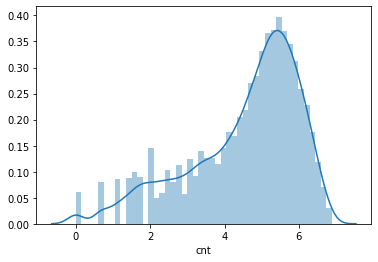

In [27]:
sns.distplot(np.log(df.cnt))
plt.show()

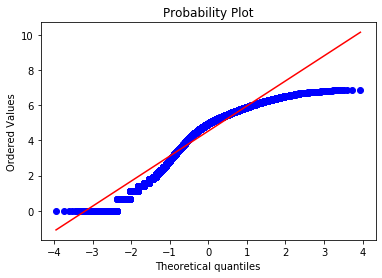

In [28]:
sp.stats.probplot(np.log(df_ols.cnt), plot=plt)
plt.show()

In [29]:
df_ols["log_cnt"]=df_ols["cnt"].apply(lambda x : np.log(x))
df_ols.head()

C:\Users\TAEHYEONG\Anaconda3\envs\DACON\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,season,hr,workingday,weathersit,temp,hum,windspeed,casual,cnt,log_cnt
0,1,0,0,1,0.24,0.81,0.0,3,16,2.772589
1,1,1,0,1,0.22,0.80,0.0,8,40,3.688879
2,1,2,0,1,0.22,0.80,0.0,5,32,3.465736
3,1,3,0,1,0.24,0.75,0.0,3,13,2.564949
4,1,4,0,1,0.24,0.75,0.0,0,1,0.000000


In [30]:
sm.OLS.from_formula("log_cnt ~ season+hr+workingday+weathersit+temp+hum+windspeed", data=df_ols).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_cnt   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     2044.
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        11:33:25   Log-Likelihood:                -17755.
No. Observations:               17379   AIC:                         3.558e+04
Df Residuals:                   17345   BIC:                         3.584e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.0046      0.039     77.287      0.000       2.928       3.081
season[T.2]         0.3316      0.018     17.923      0.000       0.295       0.368
season[T.3]         0.2366      0.024      9.900      0.000       0.190       0.283
season[T.4]         0.5198      0.016     32.457      0.000       0.488       0.551
hr[T.1]            -0.6237      0.035    -17.644      0.000      -0.693      -0.554
hr[T.2]            -1.1561      0.035    -32.598      0.000      -1.226      -1.087
hr[T.3]            -1.7340      0.036    -48.555      0.000      -1.804      -1.664
hr[T.4]            -2.0240      0.036    -56.633      0.000      -2.094      -1.954
hr[T.5]            -0.9360      0.036    -26.365      0.000      -1.006      -0.866
hr[T.6]             0.2803      0.035      7.916      0.000       0.211       0.350
hr[T.7]             1.2600      0.035     35.647      0.000       1.191       1.329
hr[T.8]             1.8872      0.035     53.432      0.000       1.818       1.956
hr[T.9]             1.5587      0.035     44.082      0.000       1.489       1.628
hr[T.10]            1.2187      0.035     34.349      0.000       1.149       1.288
hr[T.11]            1.3206      0.036     37.003      0.000       1.251       1.391
hr[T.12]            1.4930      0.036     41.550      0.000       1.423       1.563
hr[T.13]            1.4599      0.036     40.416      0.000       1.389       1.531
hr[T.14]            1.3767      0.036     37.947      0.000       1.306       1.448
hr[T.15]            1.4274      0.036     39.290      0.000       1.356       1.499
hr[T.16]            1.6843      0.036     46.443      0.000       1.613       1.755
hr[T.17]            2.0846      0.036     57.741      0.000       2.014       2.155
hr[T.18]            2.0158      0.036     56.114      0.000       1.945       2.086
hr[T.19]            1.7409      0.036     48.839      0.000       1.671       1.811
hr[T.20]            1.4614      0.035     41.176      0.000       1.392       1.531
hr[T.21]            1.2150      0.035     34.348      0.000       1.146       1.284
hr[T.22]            0.9697      0.035     27.454      0.000       0.901       1.039
hr[T.23]            0.5792      0.035     16.407      0.000       0.510       0.648
workingday[T.1]    -0.0356      0.011     -3.232      0.001      -0.057      -0.014
weathersit[T.2]    -0.0222      0.013     -1.756      0.079      -0.047       0.003
weathersit[T.3]    -0.5671      0.021    -26.625      0.000      -0.609      -0.525
weathersit[T.4]     0.0329      0.389      0.084      0.933      -0.730       0.796
temp                1.7421      0.047     37.450      0.000       1.651       1.833
hum                -0.4086      0.035    -11.524      0.000      -0.478      -0.339
windspeed          -0.3131      0.045     -6.966      0.000

***

In [31]:
df.iloc[0:round(len(df)*0.7)].tail()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
12160,2012-05-26,2,1,5,21,0,6,0,2,0.72,0.6818,0.62,0.1940,100,151,251
12161,2012-05-26,2,1,5,22,0,6,0,1,0.70,0.6667,0.74,0.2537,86,118,204
12162,2012-05-26,2,1,5,23,0,6,0,1,0.70,0.6667,0.74,0.2537,36,114,150
12163,2012-05-27,2,1,5,0,0,0,0,2,0.68,0.6364,0.69,0.1642,48,89,137
12164,2012-05-27,2,1,5,1,0,0,0,1,0.66,0.6212,0.74,0.2239,17,61,78


In [32]:
df.iloc[round(len(df)*0.7):].head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
12165,2012-05-27,2,1,5,2,0,0,0,1,0.64,0.6061,0.73,0.2239,16,45,61
12166,2012-05-27,2,1,5,3,0,0,0,1,0.64,0.6061,0.73,0.1642,11,25,36
12167,2012-05-27,2,1,5,4,0,0,0,1,0.62,0.5758,0.83,0.1940,4,7,11
12168,2012-05-27,2,1,5,5,0,0,0,1,0.62,0.5758,0.83,0.1940,2,5,7
12169,2012-05-27,2,1,5,6,0,0,0,1,0.62,0.5758,0.83,0.1642,8,14,22


In [33]:
df2=df_ols.drop('log_cnt', axis=1)
df2=pd.get_dummies(df2)
df2=df2.drop(['season_1','hr_0','workingday_0','weathersit_1'], axis=1)
df2.head()

,temp,hum,windspeed,casual,cnt,season_2,season_3,season_4,hr_1,hr_2,...,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,workingday_1,weathersit_2,weathersit_3,weathersit_4
0,0.24,0.81,0.0,3,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.22,0.80,0.0,8,40,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0.22,0.80,0.0,5,32,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0.24,0.75,0.0,3,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.24,0.75,0.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
X=df2.iloc[0:12163]
y=df2.iloc[12163:]

In [35]:
X_train = X.drop('cnt', axis=1)
X_test = X['cnt']
y_train = y.drop('cnt', axis=1)
y_test = y['cnt']

In [36]:
lr = LinearRegression().fit(X_train, X_test)
pred = lr.predict(y_train)
mse = mean_squared_error(y_test, pred)

In [37]:
mse

15474.510051808344